##Stock Forcasting using LSTM Neural Network(Time Series Forecasting)

##Methodology
We use an LSTM model for stock price forecasting because it can learn and store sequential patterns to predict the next day's closing price. LSTMs (Long Short-Term Memory networks) achieve this by maintaining a memory cell that retains relevant information over extended sequences. The LSTM structure includes gates—input, forget, and output—that regulate the flow of information. These gates selectively store or discard data from previous time steps, enabling the model to remember significant trends and patterns while ignoring irrelevant details. By doing this, the LSTM network can adjust its internal weights to refine predictions, leading to more accurate forecasts of future stock prices.






In [ ]:

# Importing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# Path to the CSV file
file_path = 'EURUSD=X.csv'

# Load the data into a DataFrame
data = pd.read_csv(file_path)


data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0.0
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0.0
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0.0
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0.0
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0.0
...,...,...,...,...,...,...,...
5325,2024-04-29,1.070687,1.073537,1.069096,1.070687,1.070687,0.0
5326,2024-04-30,1.071570,1.073653,1.068433,1.071570,1.071570,0.0
5327,2024-05-01,1.066655,1.068867,1.065008,1.066655,1.066655,0.0
5328,2024-05-02,1.072156,1.073076,1.067578,1.072156,1.072156,0.0


##Data Cleaning
We're eliminating all unnecessary features, focusing exclusively on closing costs. Our LSTM model will specifically predict the closing price of the stock.

In [ ]:
data = data[['Date','Close']]
data

,Date,Close
0,2003-12-01,1.196501
1,2003-12-02,1.208897
2,2003-12-03,1.212298
3,2003-12-04,1.208094
4,2003-12-05,1.218695
...,...,...
5325,2024-04-29,1.070687
5326,2024-04-30,1.071570
5327,2024-05-01,1.066655
5328,2024-05-02,1.072156


Using CPU if TPU not available or if nessisary for larger runtime issues.

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

##Ploting Raw data from Gamestop data set.

<ipython-input-530-efc1deca1d5e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] =pd.to_datetime(data['Date'])


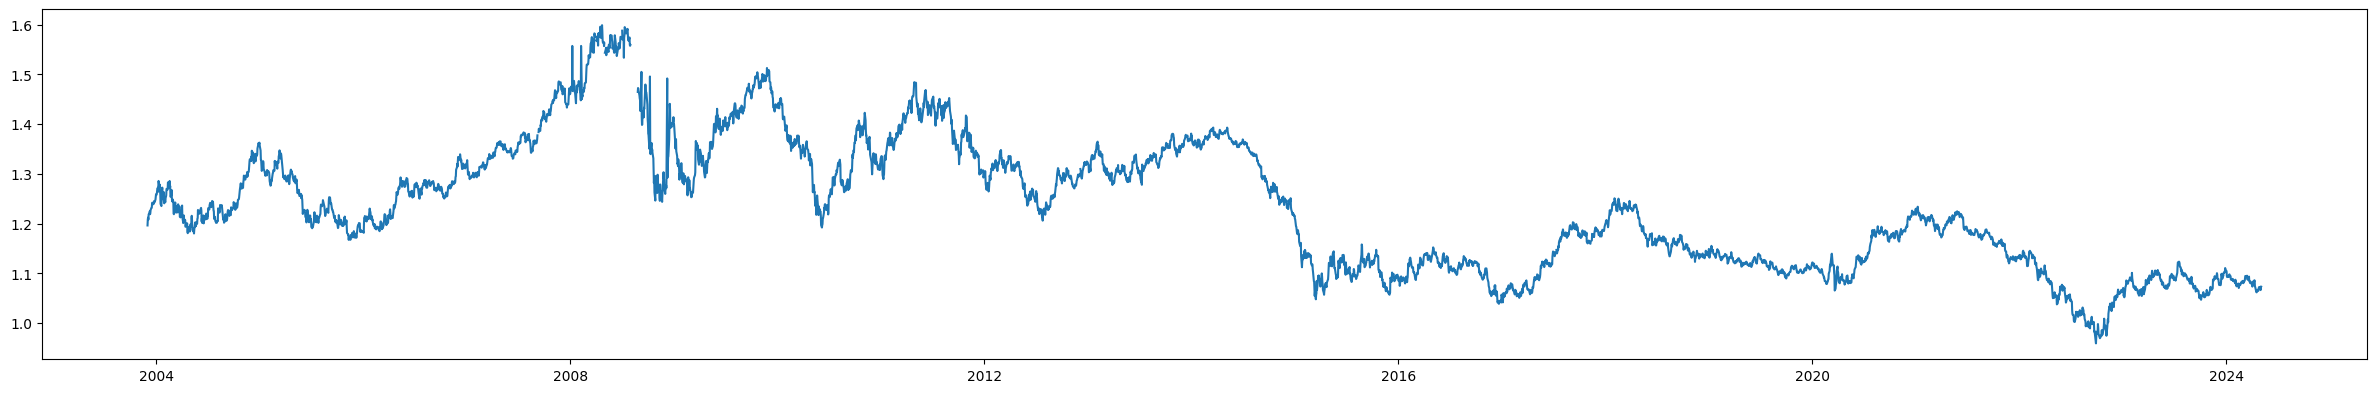

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(2,1,1)
data['Date'] =pd.to_datetime(data['Date'])
plt.plot(data['Date'], data['Close'])

#Preparing the data![GME_ACTUAL_VS.png](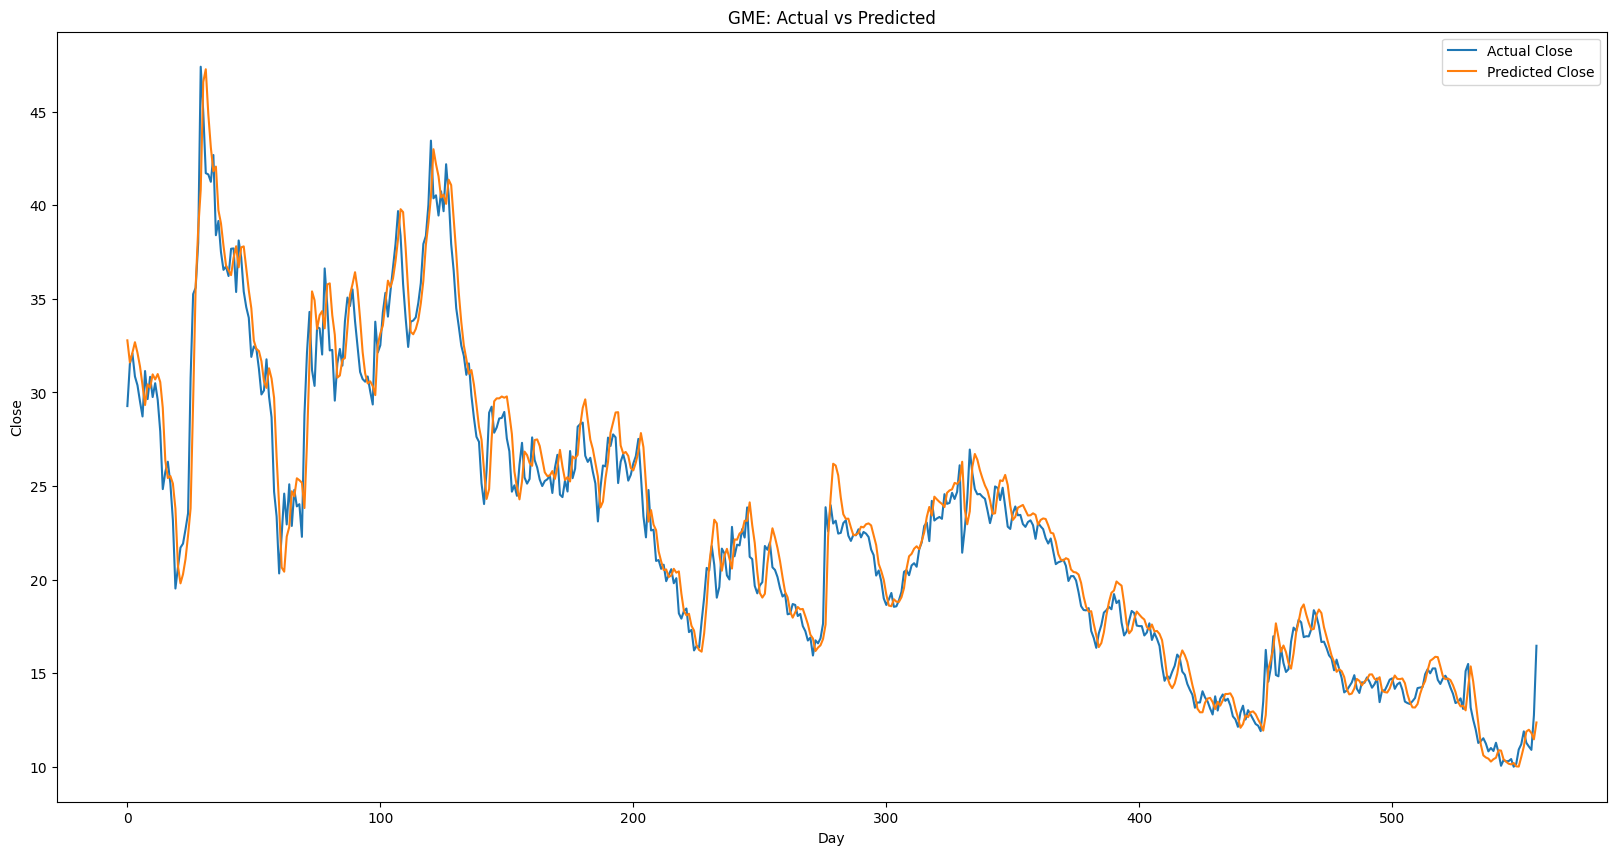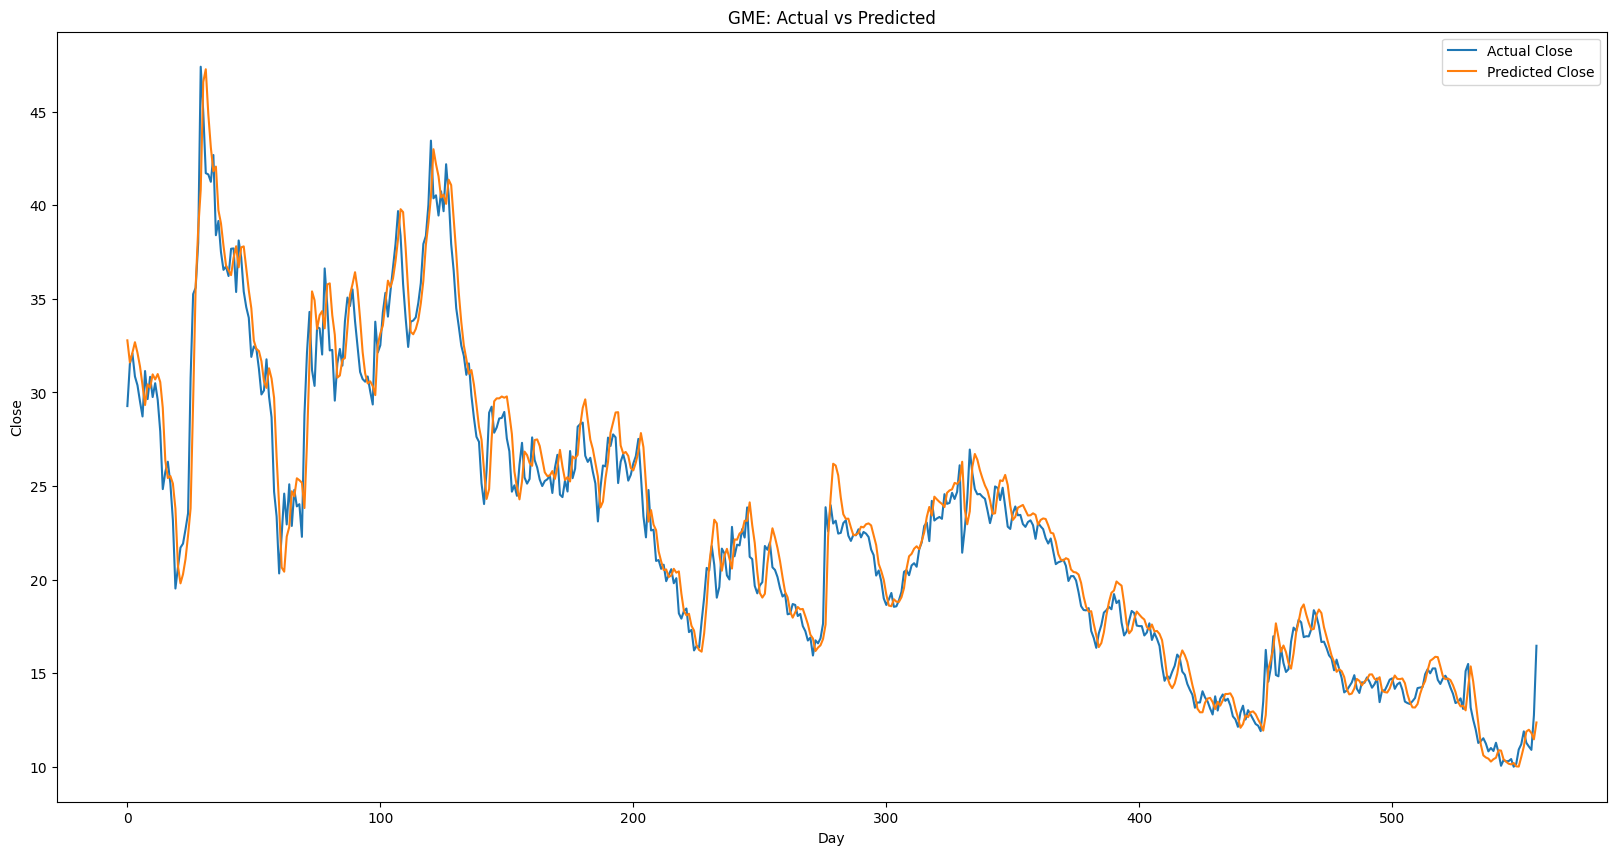)
*   Prepares a time-series dataframe for the LSTM Model.

*  We will prepare the data to contain a historical time step look back of n amount of days


In [ ]:
from copy import deepcopy as dc
def prepare_dataframe(df, n_steps):
  df = dc(df)
  df['Date'] = pd.to_datetime(df['Date'])

  df.set_index('Date', inplace=True)

  for i in range(1,n_steps+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  df.dropna(inplace= True)
  return df

lookback = 20
shifted_df = prepare_dataframe(data,lookback)
shifted_df


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-11),Close(t-12),Close(t-13),Close(t-14),Close(t-15),Close(t-16),Close(t-17),Close(t-18),Close(t-19),Close(t-20)
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-29,1.248393,1.243194,1.244803,1.245299,1.240003,1.239895,1.238497,1.242298,1.240202,1.232195,...,1.227898,1.222404,1.219096,1.224995,1.222001,1.218695,1.208094,1.212298,1.208897,1.196501
2003-12-30,1.254894,1.248393,1.243194,1.244803,1.245299,1.240003,1.239895,1.238497,1.242298,1.240202,...,1.231997,1.227898,1.222404,1.219096,1.224995,1.222001,1.218695,1.208094,1.212298,1.208897
2003-12-31,1.259002,1.254894,1.248393,1.243194,1.244803,1.245299,1.240003,1.239895,1.238497,1.242298,...,1.232195,1.231997,1.227898,1.222404,1.219096,1.224995,1.222001,1.218695,1.208094,1.212298
2004-01-01,1.258194,1.259002,1.254894,1.248393,1.243194,1.244803,1.245299,1.240003,1.239895,1.238497,...,1.240202,1.232195,1.231997,1.227898,1.222404,1.219096,1.224995,1.222001,1.218695,1.208094
2004-01-02,1.258194,1.258194,1.259002,1.254894,1.248393,1.243194,1.244803,1.245299,1.240003,1.239895,...,1.242298,1.240202,1.232195,1.231997,1.227898,1.222404,1.219096,1.224995,1.222001,1.218695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,1.070687,1.072961,1.069988,1.070435,1.065405,1.065825,1.064419,1.066940,1.062146,1.062575,...,1.072685,1.074172,1.085930,1.086366,1.083048,1.083705,1.083835,1.076855,1.073722,1.079273
2024-04-30,1.071570,1.070687,1.072961,1.069988,1.070435,1.065405,1.065825,1.064419,1.066940,1.062146,...,1.064963,1.072685,1.074172,1.085930,1.086366,1.083048,1.083705,1.083835,1.076855,1.073722
2024-05-01,1.066655,1.071570,1.070687,1.072961,1.069988,1.070435,1.065405,1.065825,1.064419,1.066940,...,1.062575,1.064963,1.072685,1.074172,1.085930,1.086366,1.083048,1.083705,1.083835,1.076855


## Converting to a numpy.

In [ ]:
shifted_df_np = shifted_df.to_numpy()
shifted_df_np

array([[1.248393, 1.243194, 1.244803, ..., 1.212298, 1.208897, 1.196501],
       [1.254894, 1.248393, 1.243194, ..., 1.208094, 1.212298, 1.208897],
       [1.259002, 1.254894, 1.248393, ..., 1.218695, 1.208094, 1.212298],
       ...,
       [1.066655, 1.07157 , 1.070687, ..., 1.083705, 1.083835, 1.076855],
       [1.072156, 1.066655, 1.07157 , ..., 1.083048, 1.083705, 1.083835],
       [1.073537, 1.072156, 1.066655, ..., 1.086366, 1.083048, 1.083705]])

##Normalizing the data
Between -1 and 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_np = scaler.fit_transform(shifted_df_np)

shifted_df_np

array([[-0.07263662, -0.08933259, -0.08416548, ..., -0.18383622,
        -0.1948216 , -0.2458233 ],
       [-0.05175944, -0.07263662, -0.08933259, ..., -0.19741532,
        -0.18383622, -0.20635734],
       [-0.03856708, -0.05175944, -0.07263662, ..., -0.16317365,
        -0.19741532, -0.19552936],
       ...,
       [-0.65626661, -0.64048267, -0.64331832, ..., -0.59919701,
        -0.59877711, -0.62674809],
       [-0.6386008 , -0.65626661, -0.64048267, ..., -0.60131915,
        -0.59919701, -0.6045254 ],
       [-0.63416588, -0.6386008 , -0.65626661, ..., -0.59060187,
        -0.60131915, -0.60493929]])

extract the first column to (actual close) y and the rest of the columns will hold the featues of the dataset to train

In [ ]:
x = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]
x = dc(np.flip(x, axis = 1))
x.shape, y.shape


((5005, 20), (5005,))

##Spliting data
*   90% train and 10% test for GME
*   80% train and 20% test for EUDUSD and Bitcoin



In [ ]:
split_index = int(len(x) *.80)
split_index

4004

##Preparing data for pytorch LSTM
Also to ensure there is no leakage from the training to the test portion of the data we will eliminate 20 days from the training portion.

In [ ]:
x_train = x[:split_index-lookback]
x_test = x[split_index:]

y_train = y[:split_index-lookback]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3984, 20), (1001, 20), (3984,), (1001,))

## Reshaping Matrices
To ensure our PyTorch LSTM functions properly, we need an additional dimension. We're reshaping the data to meet this requirement.

In [ ]:
x_train = x_train.reshape((-1,lookback, 1))
x_test = x_test.reshape((-1,lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3984, 20, 1), (1001, 20, 1), (3984, 1), (1001, 1))

#

#Wrap the time-series data
We will wrap the data into a format that is easily used by pytorch with data loaders to facilitate batch proccessing, shuffling.  We create a training and a testing timeseriesDataset for training and for validation in the model.

In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, x, y):
    self.x = x #Matrix x
    self.y = y # output vector y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return self.x[i], self.y[i]

train_dataset = TimeSeriesDataset(x_train,y_train) #Pass in dataset
test_dataset = TimeSeriesDataset(x_test,y_test)
train_dataset


set the batch size and set the dataloader with our previously made timeseriesData sets. Set shuffle to true on the training to randomize the order of the datapoints.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#fetch batches of data
This is designed to fetch the first batch of data (x_batch and y_batch)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0] , batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([50, 20, 1]) torch.Size([50, 1])


#Evaluate performance method
This will compute the loss and validate the machine learning model. This will display the loss over all batches in the dataset to assess how well the model can generalize to new unseen data.

In [ ]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch.float())
            loss = loss_function(output, y_batch.float())
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    print('Val loss: {0:.3f}'.format(avg_loss_across_batches))
    print('****************************************************')
    print()


#Trains for one epoch
processes all the data in train_loader once, updating the models paramters(weight, bias) to minimize the loss function.

In [ ]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch.float())  # Convert x_batch to float tensor
        loss = loss_function(output, y_batch.float())  # Convert y_batch to float tensor
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0

    print()


#The LSTM model
the LSTM model with 8 hiddden layers. Keeping it simple.

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):# number of features, howevery dimentions in the center and stacked layer.
    super(). __init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.shape[0]
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])

    return out
model = LSTM(1,8,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

#Training Loop
Here we run the previous methods we created to train followed by validation per eopch to see the performance of the model.

In [ ]:

epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
  train_one_epoch()
  validate_one_epoch()


Epoch: 1

Val loss: 0.200
****************************************************

Epoch: 2

Val loss: 0.009
****************************************************

Epoch: 3

Val loss: 0.008
****************************************************

Epoch: 4

Val loss: 0.006
****************************************************

Epoch: 5

Val loss: 0.004
****************************************************

Epoch: 6

Val loss: 0.003
****************************************************

Epoch: 7

Val loss: 0.002
****************************************************

Epoch: 8

Val loss: 0.002
****************************************************

Epoch: 9

Val loss: 0.002
****************************************************

Epoch: 10

Val loss: 0.001
****************************************************

Epoch: 11

Val loss: 0.002
****************************************************

Epoch: 12

Val loss: 0.002
****************************************************

Epoch: 13

Val loss: 0.001
**********

#Training of the first 90% of the data plotted without reverting the scale

<function matplotlib.pyplot.show(close=None, block=None)>

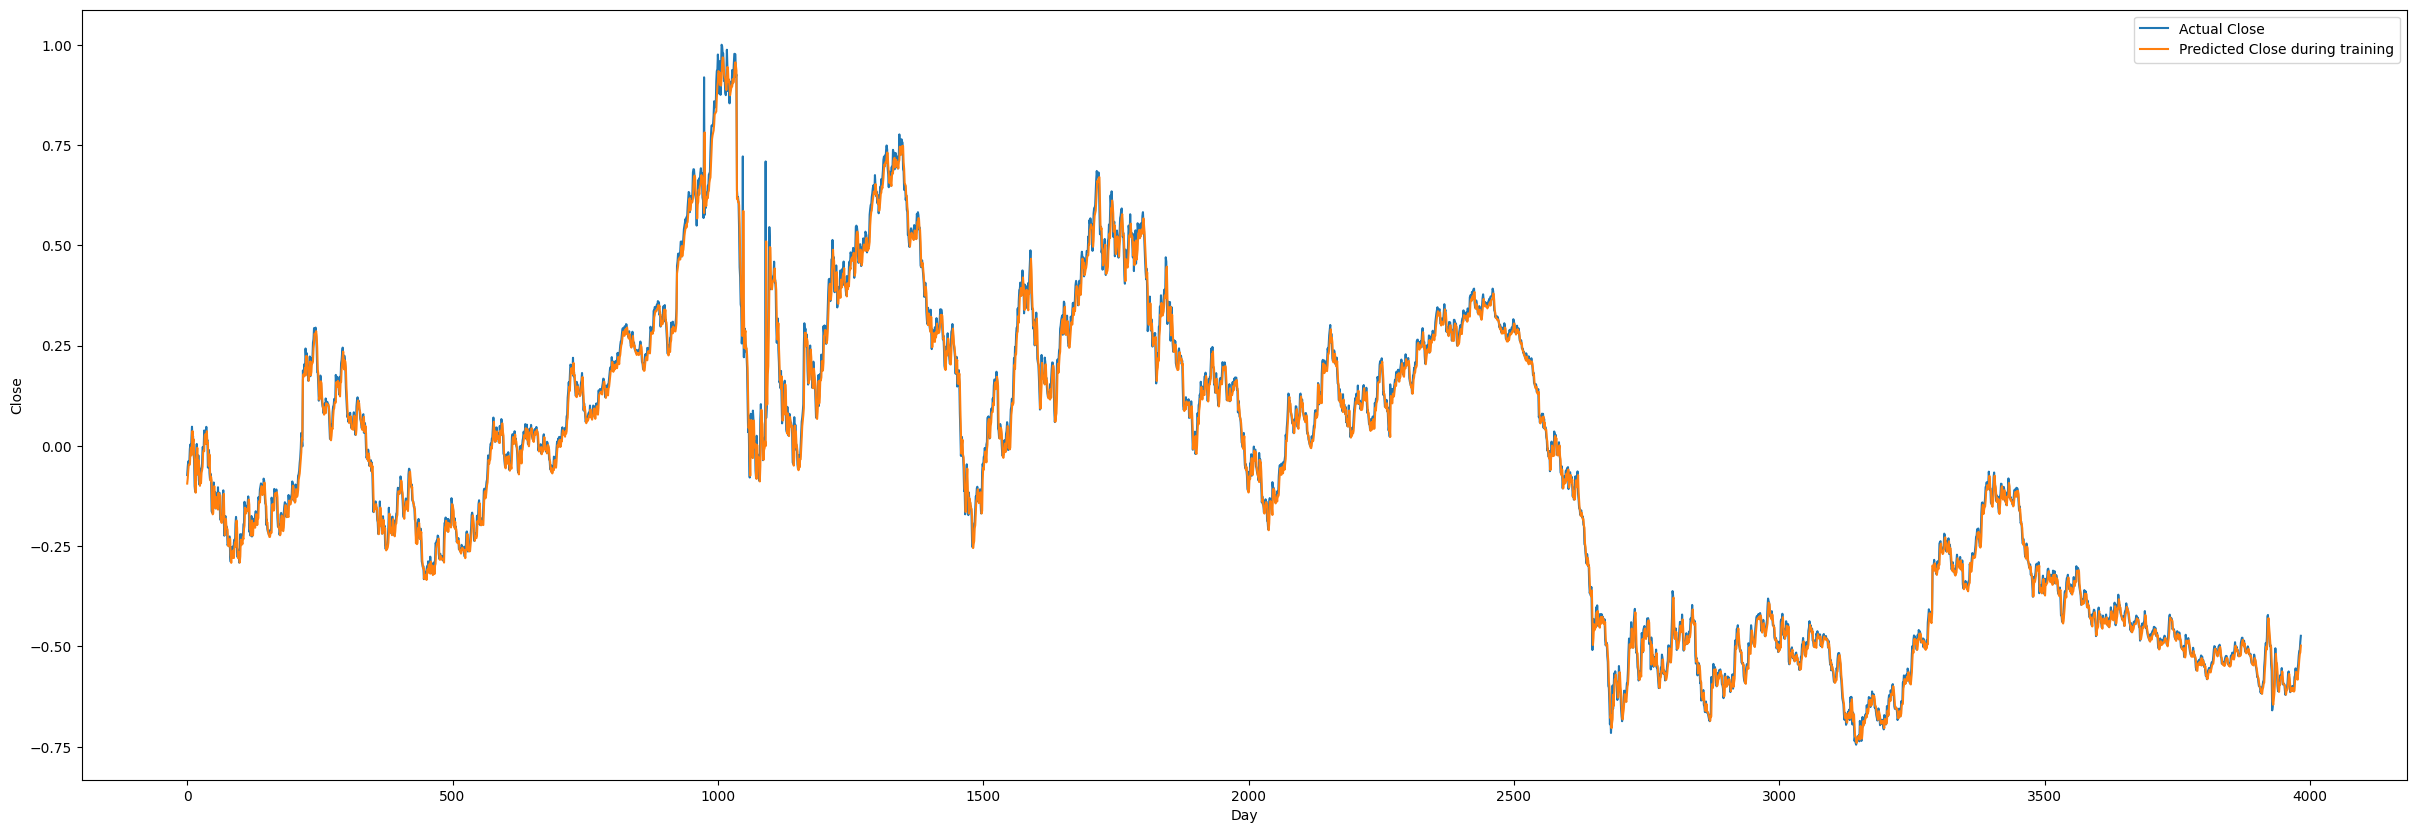

In [ ]:
with torch.no_grad():
  predicted = model(torch.tensor(x_train, dtype=torch.float32).to(device)).to('cpu').detach().numpy()

plt.figure(figsize=(30, 10))
plt.plot(y_train, label = 'Actual Close')
plt.plot(predicted, label = 'Predicted Close during training')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()

plt.show

##Scaling values back to original values for predictions/ x_train

In [ ]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([1.2417485 , 1.2458244 , 1.2520299 , ..., 1.10924491, 1.11073784,
       1.11599459])

##Scaling values back to original values for actual/y_train

In [ ]:
dummies = np.zeros((x_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([1.248393, 1.254894, 1.259002, ..., 1.112595, 1.118944, 1.123595])

#Plot again with original scale of the data

<function matplotlib.pyplot.show(close=None, block=None)>

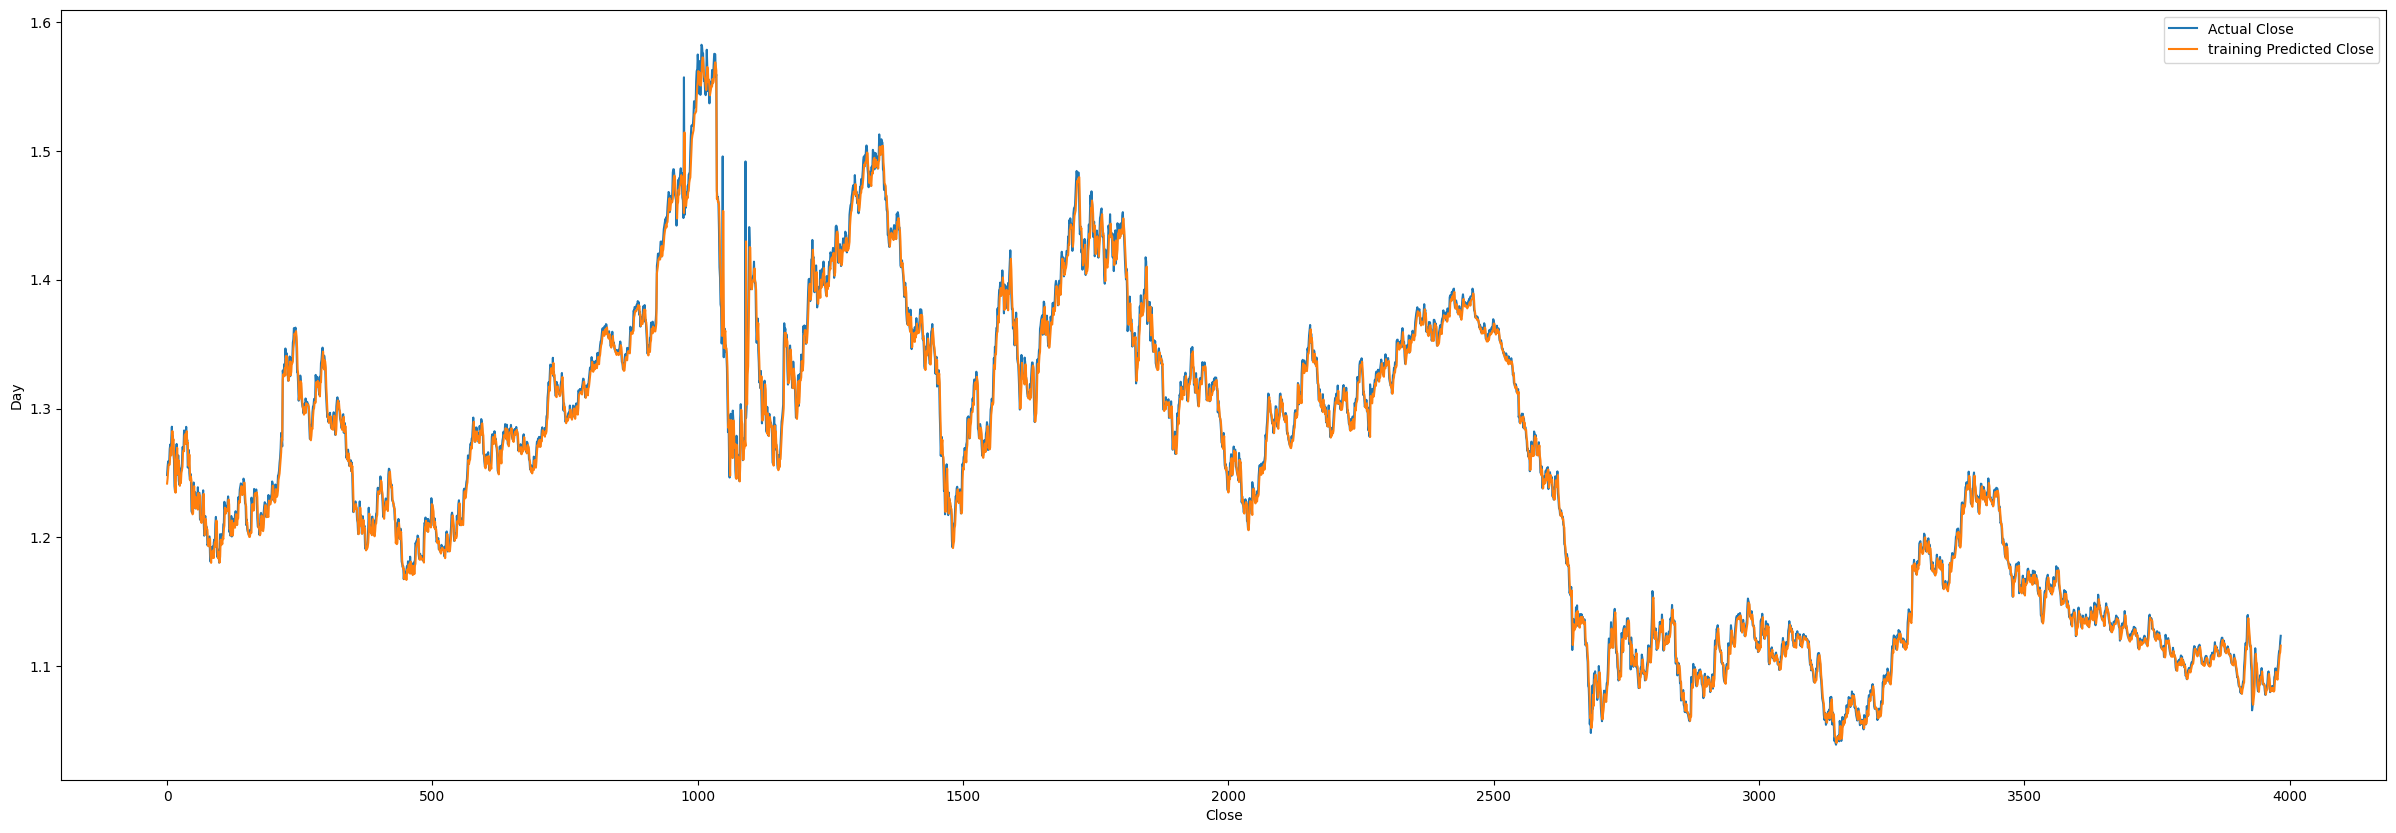

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(new_y_train, label = 'Actual Close')
plt.plot(train_predictions, label = 'training Predicted Close')
plt.xlabel('Close')
plt.ylabel('Day')
plt.legend()

plt.show

#Convert x_test predictions (Unseen data)
get the predictions for the unseen data and convert back to the original scale.

In [ ]:
test_predictions = model(torch.tensor(x_test, dtype=torch.float32).to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])
test_predictions

array([1.12335458, 1.12252775, 1.12307266, ..., 1.07073146, 1.067233  ,
       1.07044873])

reverse scaling to bring back to original scale

In [ ]:
dummies = np.zeros((x_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])
new_y_test

array([1.123785, 1.12472 , 1.131286, ..., 1.066655, 1.072156, 1.073537])

#Plot actual versus prediction

<function matplotlib.pyplot.show(close=None, block=None)>

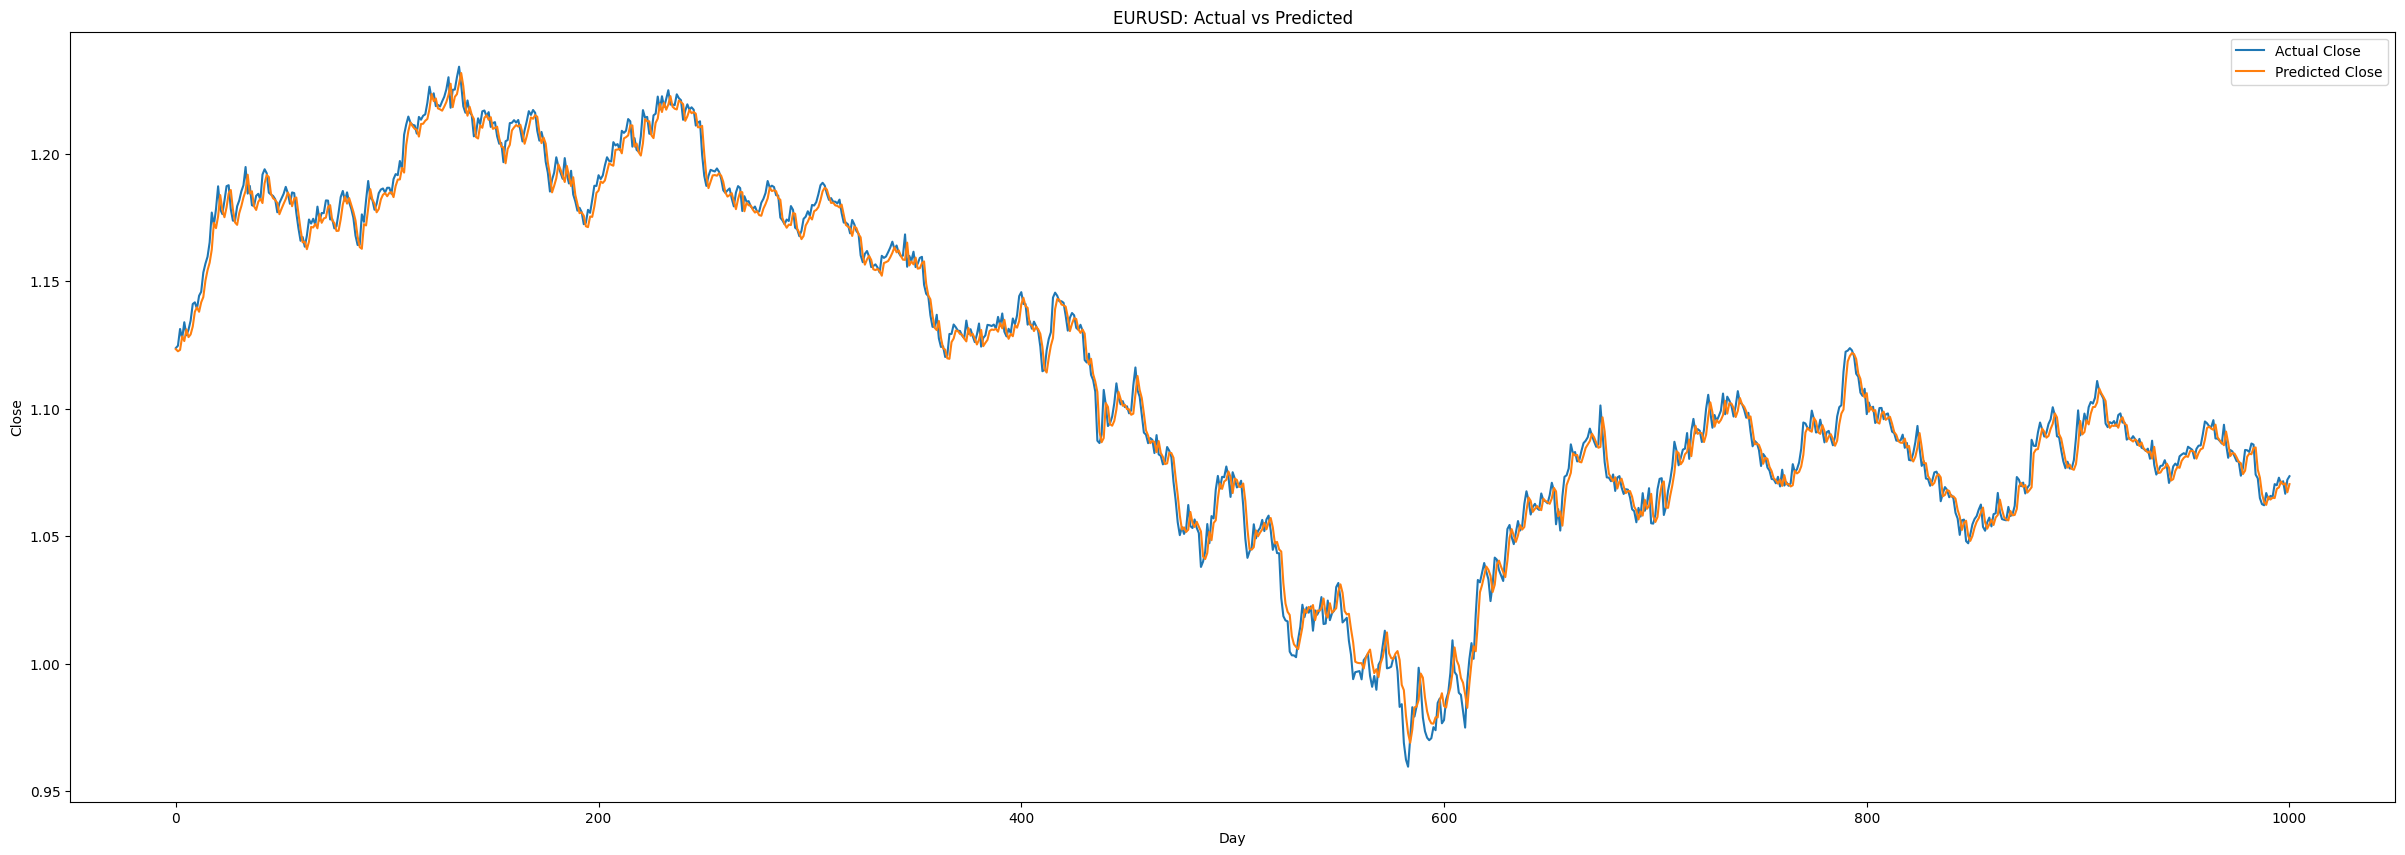

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(new_y_test, label = 'Actual Close')
plt.plot(test_predictions, label = 'Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('EURUSD: Actual vs Predicted')
plt.legend()

plt.show

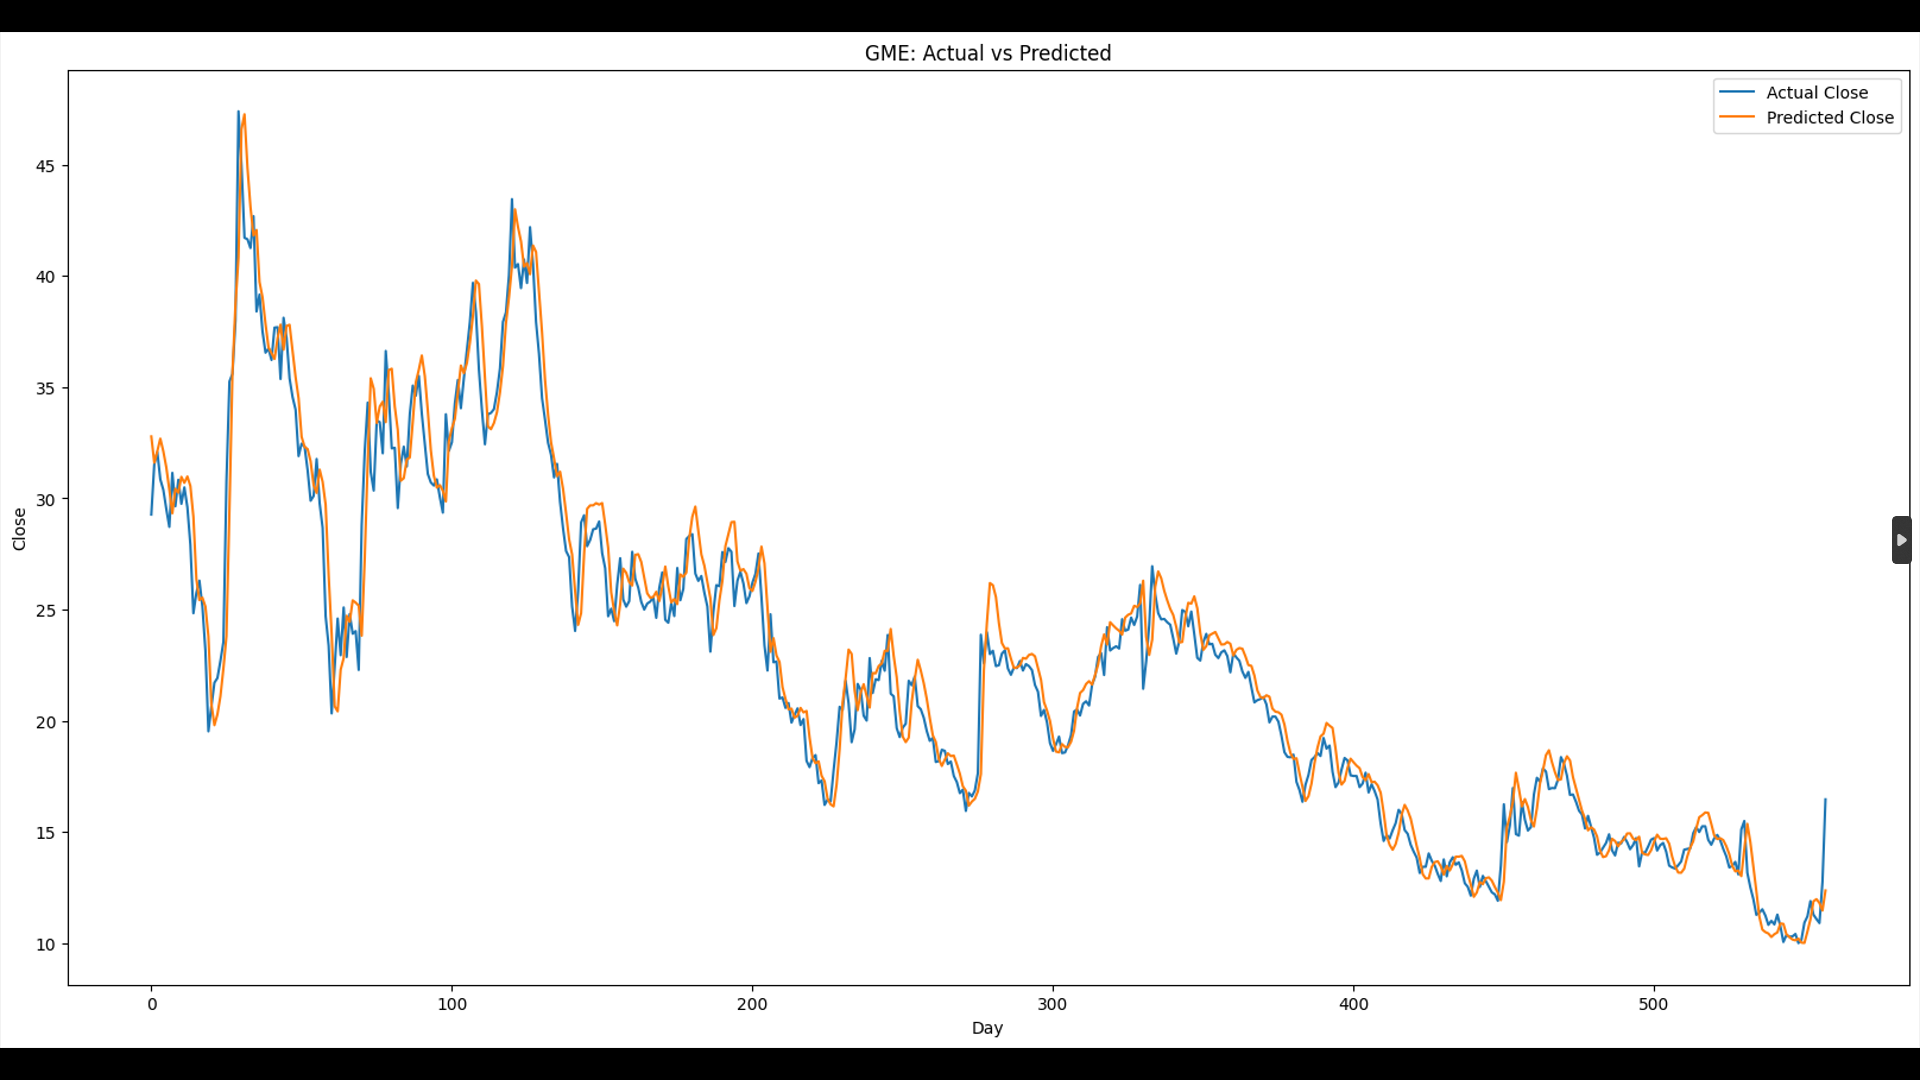

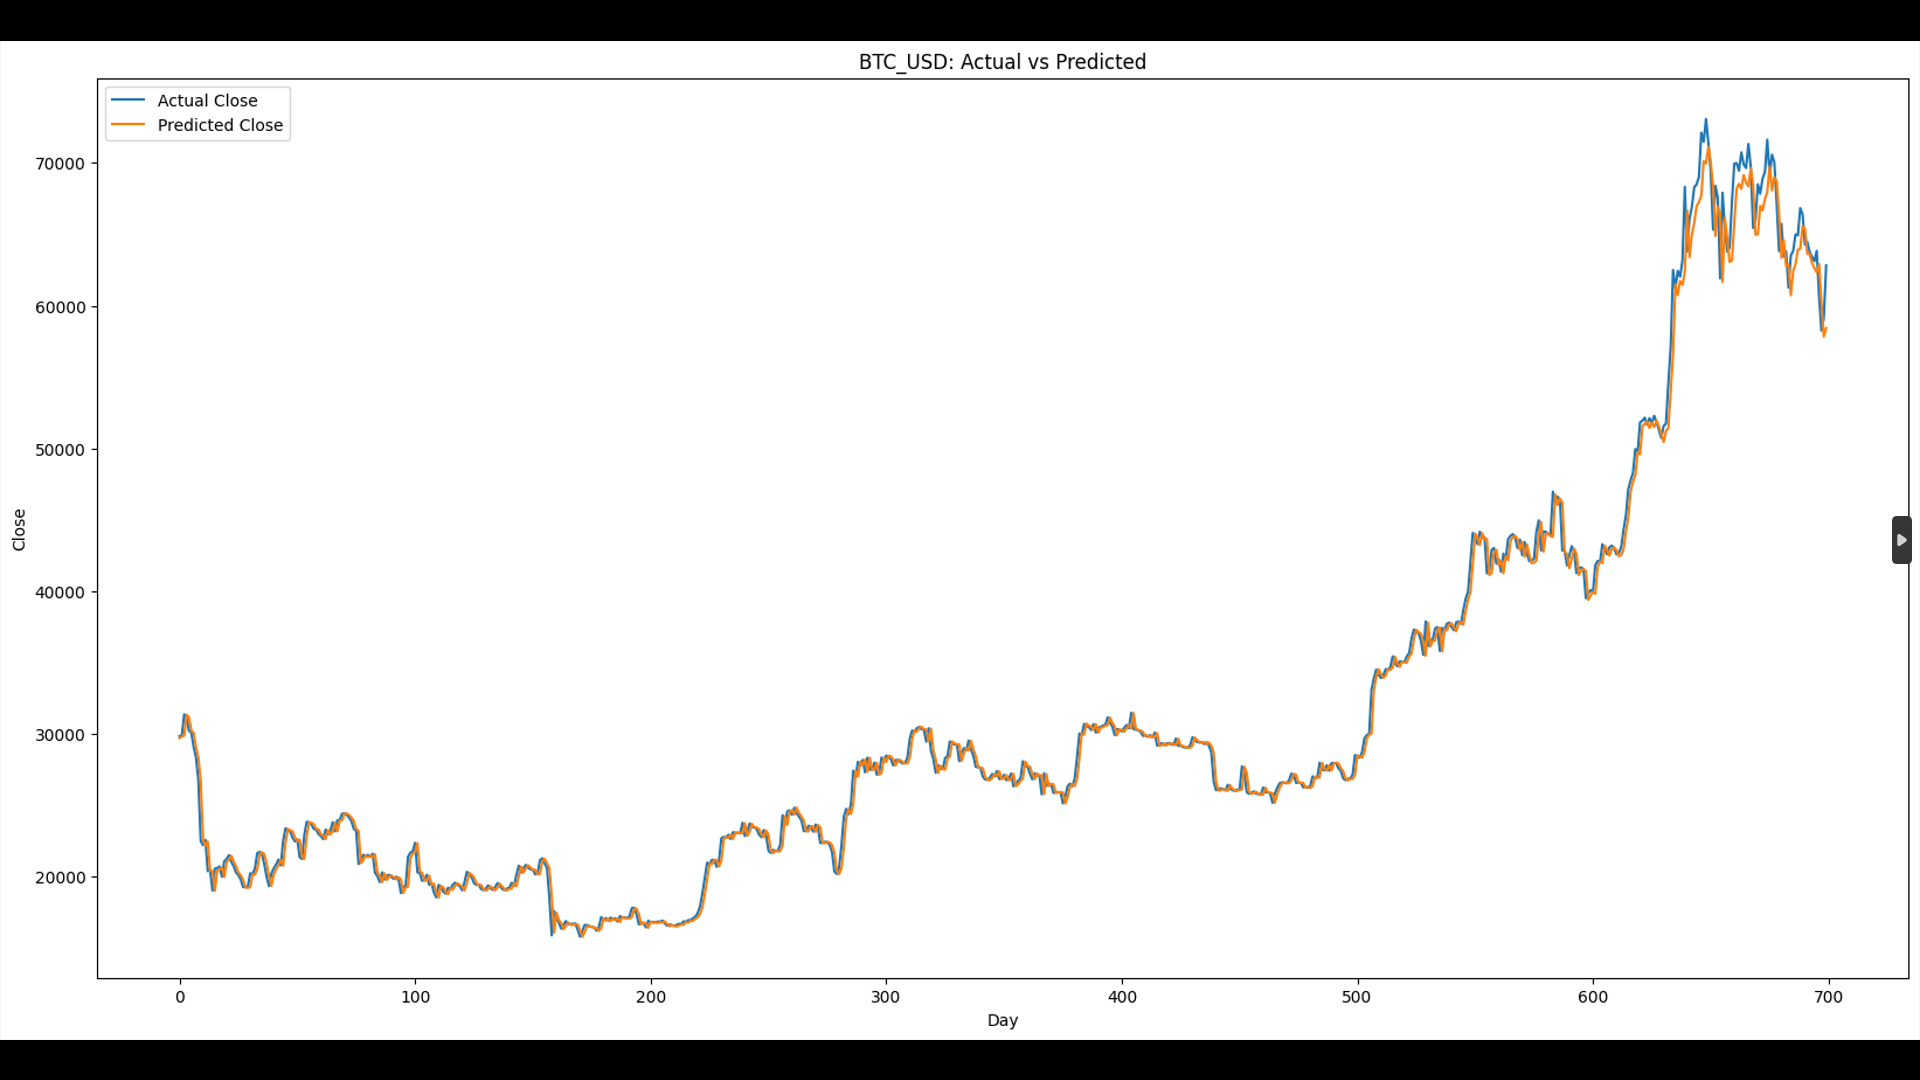#GME ACTUAL versus Predicted


In [ ]:
def classify_market_trend(dates, actual_closes, predicted_closes, threshold=0.0001):
    trends = []
    # Ensure you have the same number of dates as actual_closes and predicted_closes
    for date, actual, predicted in zip(dates[split_index:-1], actual_closes[:-1], predicted_closes[1:]):  # adjust indexing for predictions

        formatted_date = date.strftime('%Y-%m-%d')
        if predicted > actual * (1 + threshold):  # Predicted next day price is higher beyond the threshold
            trend = 'Buy'  # Using 'Buy' for bullish trend
        elif predicted < actual * (1 - threshold):  # Predicted next day price is lower beyond the threshold
            trend = 'Sell'  # Using 'Sell' for bearish trend
        else:
            trend = 'Neutral'  # No significant change
        trends.append((formatted_date, trend))
    return trends


buyorsell = classify_market_trend(data['Date'], new_y_test, test_predictions)
buyorsell

[('2019-04-05', 'Sell'),
 ('2019-04-08', 'Sell'),
 ('2019-04-09', 'Sell'),
 ('2019-04-10', 'Sell'),
 ('2019-04-11', 'Sell'),
 ('2019-04-12', 'Sell'),
 ('2019-04-15', 'Sell'),
 ('2019-04-16', 'Sell'),
 ('2019-04-17', 'Sell'),
 ('2019-04-18', 'Sell'),
 ('2019-04-19', 'Sell'),
 ('2019-04-22', 'Sell'),
 ('2019-04-23', 'Sell'),
 ('2019-04-24', 'Sell'),
 ('2019-04-25', 'Sell'),
 ('2019-04-26', 'Sell'),
 ('2019-04-29', 'Sell'),
 ('2019-04-30', 'Sell'),
 ('2019-05-01', 'Sell'),
 ('2019-05-02', 'Sell'),
 ('2019-05-03', 'Sell'),
 ('2019-05-06', 'Sell'),
 ('2019-05-07', 'Sell'),
 ('2019-05-08', 'Sell'),
 ('2019-05-09', 'Sell'),
 ('2019-05-10', 'Sell'),
 ('2019-05-13', 'Neutral'),
 ('2019-05-14', 'Sell'),
 ('2019-05-15', 'Sell'),
 ('2019-05-16', 'Sell'),
 ('2019-05-17', 'Sell'),
 ('2019-05-20', 'Sell'),
 ('2019-05-21', 'Sell'),
 ('2019-05-22', 'Sell'),
 ('2019-05-23', 'Neutral'),
 ('2019-05-24', 'Sell'),
 ('2019-05-27', 'Sell'),
 ('2019-05-28', 'Sell'),
 ('2019-05-29', 'Sell'),
 ('2019-05-30', 'Se

3. Iterative Prediction
For predicting future values beyond your available data:

Start with the last known sequence: Use this sequence to predict the next data point.
Update the sequence: Incorporate the predicted data point into the sequence, usually by dropping the oldest point in the sequence and adding the predicted point at the end.
Predict again: Use the updated sequence to predict the next point.
Repeat: Continue this process for as many future steps as you want to predict.


In [ ]:
import torch

def predict_future_values(model, last_sequence, num_predictions):
    future_predictions = []
    if isinstance(last_sequence, list) or len(last_sequence.shape) == 1:
        last_sequence = np.array(last_sequence).reshape(-1, 1)

    # Convert to a 3D tensor: (batch_size=1, sequence_length, num_features=1)
    last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)

    assert last_sequence_tensor.ndim == 3, "Input to LSTM should be 3D."

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for _ in range(num_predictions):
            # Predict the next value using the model
            next_value = model(last_sequence_tensor)
            next_value = next_value.squeeze().item()  # Reduce to scalar (from 2 to 1)

            # Append to the list of predictions
            future_predictions.append(next_value)

            # Update the sequence to include the predicted value
            last_sequence_tensor = torch.roll(last_sequence_tensor, -1, dims=1)
            last_sequence_tensor[:, -1, 0] = next_value

    return future_predictions

In [ ]:
import pandas as pd

def generate_future_dates(start_date, num_days):
    return pd.date_range(start=start_date, periods=num_days, freq='B').strftime('%Y-%m-%d').tolist()

# start_date = last known date in your dataset
# num_days = same as num_predictions
# future_dates = generate_future_dates(start_date, num_predictions)


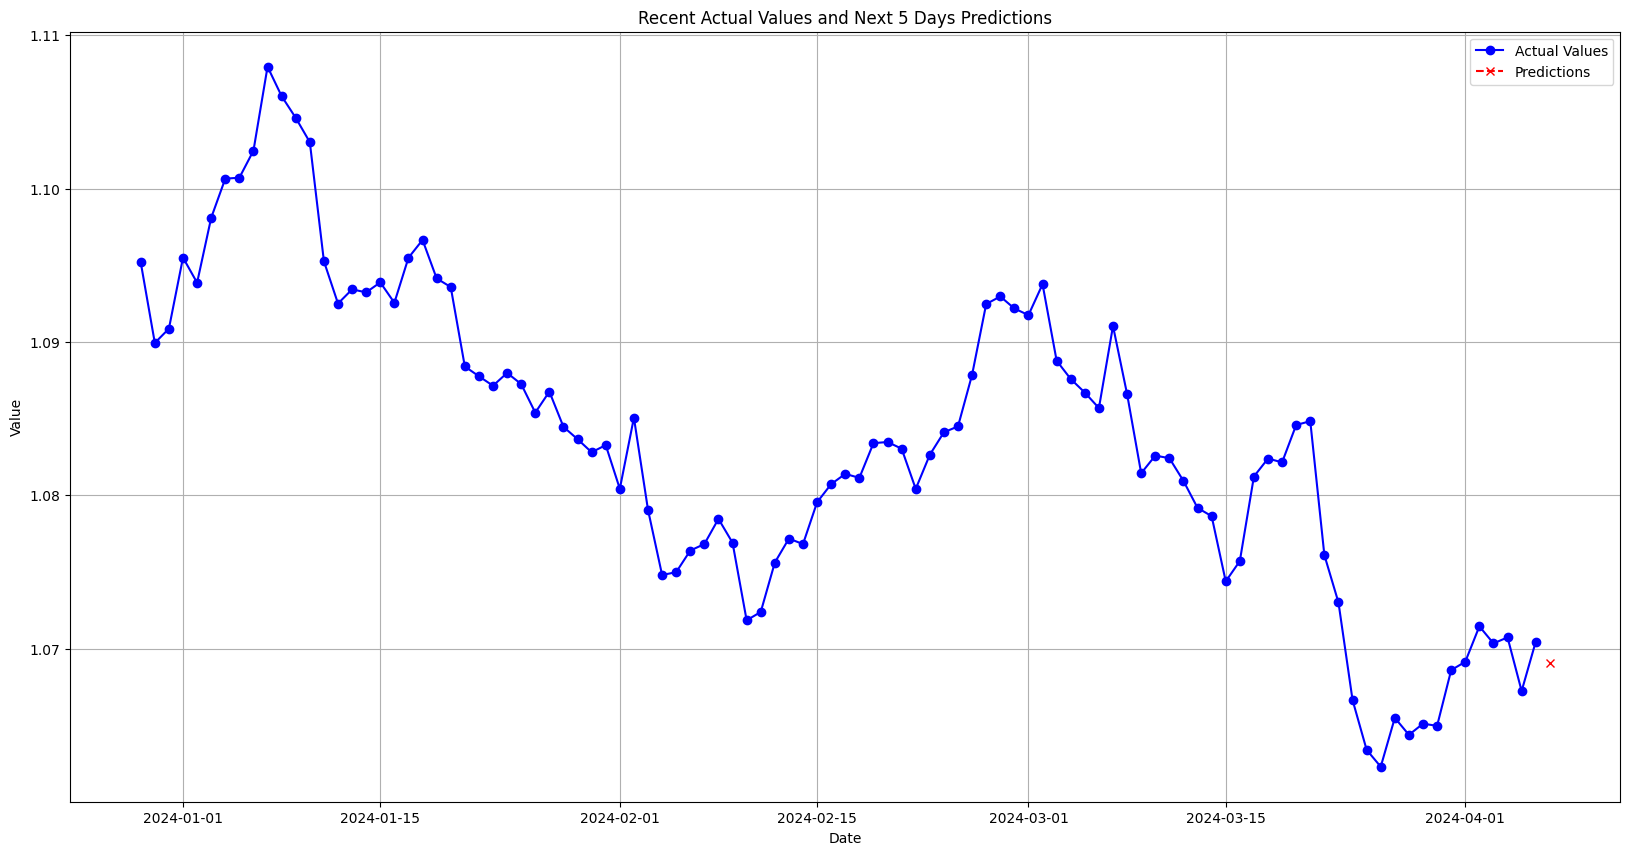

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

predictions = predict_future_values(model, new_y_test, 1)

# Generating date ranges
# Use only the last segment of the actual data; adjust 'days_to_show' as needed
days_to_show = 100  # Number of days of actual data to display
len_actual = len(new_y_test)
len_pred = len(predictions)

actual_dates = pd.date_range(end='2024-4-6', periods=days_to_show, freq='D')
prediction_dates = pd.date_range(start=actual_dates[-1] + pd.Timedelta(days=1), periods=len_pred, freq='D')


data_actual = pd.DataFrame({
    'Date': actual_dates,
    'Value': test_predictions[-days_to_show:]  # Last 'days_to_show' actual data points
})

data_predictions = pd.DataFrame({
    'Date': prediction_dates,
    'Value': predictions #Only show the dates that have yet to pass
})

# Plotting
plt.figure(figsize=(20, 10))
plt.plot(data_actual['Date'], data_actual['Value'], label='Actual Values', marker='o', linestyle='-', color='blue')
plt.plot(data_predictions['Date'], data_predictions['Value'], label='Predictions', marker='x', linestyle='--', color='red')
plt.title('Recent Actual Values and Next 5 Days Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
